In [2]:
import pandas as pd
df = pd.read_csv("/dev/extraordinary_full_scrape.csv")
print(df.shape)
df.head()

(5000, 9)


,merchant_name,merchant_category,purchase_channel,amount,country,metadata,source,scrape_date,best_card
0,BookStore Direct,online_retail,online,69.89,US,HTML_Scrape,real_crawler,2025-04-22,Card_Flat
1,BookStore Direct,online_retail,online,72.55,US,HTML_Scrape,real_crawler,2025-07-02,Card_Flat
2,BookStore Direct,online_retail,online,67.64,US,HTML_Scrape,real_crawler,2025-08-14,Card_Flat
3,BookStore Direct,online_retail,online,64.56,US,HTML_Scrape,real_crawler,2025-01-14,Card_Flat
4,BookStore Direct,online_retail,online,73.21,US,HTML_Scrape,real_crawler,2025-01-27,Card_Flat


In [3]:
import numpy as np
import pandas as pd
import random


def add_complexity(df_in, seed=42):
    df = df_in.copy()
    np.random.seed(seed)
    random.seed(seed)

    # 1. TIME FEATURES
    df['scrape_date'] = pd.to_datetime(df['scrape_date'], errors='coerce')
    df['month'] = df['scrape_date'].dt.month
    df['dayofweek'] = df['scrape_date'].dt.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

    # 2. USER SEGMENT
    def assign_segment(row):
        cat = row['merchant_category']
        if cat in ['grocery', 'gas']:
            return np.random.choice(['Family Shopper', 'Budget Shopper', 'Commuter'], p=[0.55, 0.25, 0.20])
        if cat == 'travel':
            return np.random.choice(['Frequent Traveler', 'Business Traveler', 'Occasional Traveler'], p=[0.50, 0.30, 0.20])
        if cat in ['dining', 'subscription']:
            return np.random.choice(['Foodie', 'Entertainment Lover', 'Casual Spender'], p=[0.40, 0.40, 0.20])
        return np.random.choice(['Online Bargain Hunter', 'General Shopper'], p=[0.55, 0.45])

    df['user_segment'] = df.apply(assign_segment, axis=1)

    # 3. FOREIGN TRANSACTIONS
    df['is_foreign'] = 0
    df.loc[df['merchant_category'] == 'travel', 'is_foreign'] = np.random.choice([0, 1], size=len(df[df['merchant_category'] == 'travel']), p=[0.7, 0.3])
    df.loc[df['is_foreign'] == 1, "country"] = "Non-US"

    def compute_rewards_nonlinear(row):
        amt = row['amount']
        cat = row['merchant_category']

        # BASE RATES FOR CARDS
        # Flat card is the "Safety Net" at 2%
        r_flat = amt * 0.02

        r_travel = amt * 0.01
        r_grocery = amt * 0.01

        if cat == 'grocery':
            if 50 <= amt <= 150:
                r_grocery = amt * 0.05
            else:
                r_grocery = amt * 0.01
        elif cat == 'dining':
            if 20 <= amt <= 100:
                r_travel = amt * 0.04
            else:
                r_travel = amt * 0.01

        elif cat == 'gas':
            if amt < 60:
                r_grocery = amt * 0.04
            else:
                r_grocery = amt * 0.01

        elif cat == 'travel':
            if amt > 300:
                r_travel = amt * 0.03 + 10 # Adding Bonus for big trips
            else:
                r_travel = amt * 0.01

        r_flat   += np.random.normal(0, 0.05)
        r_travel += np.random.normal(0, 0.05)
        r_grocery += np.random.normal(0, 0.05)

        return r_travel, r_grocery, r_flat


    df[['reward_travel', 'reward_grocery', 'reward_flat']] = df.apply(
        compute_rewards_nonlinear, axis=1, result_type='expand'
    )


    df['best_card'] = df.apply(
        lambda r: max(
            {"Card_Travel": r['reward_travel'],
             "Card_Grocery": r['reward_grocery'],
             "Card_Flat": r['reward_flat']},
            key=lambda k: {"Card_Travel": r['reward_travel'],
                           "Card_Grocery": r['reward_grocery'],
                           "Card_Flat": r['reward_flat']}[k]
        ),
        axis=1
    )

    return df

In [4]:
import pandas as pd

df_raw = pd.read_csv("/dev/extraordinary_full_scrape.csv")
print(df_raw.shape)
df_raw.head()

(5000, 9)


,merchant_name,merchant_category,purchase_channel,amount,country,metadata,source,scrape_date,best_card
0,BookStore Direct,online_retail,online,69.89,US,HTML_Scrape,real_crawler,2025-04-22,Card_Flat
1,BookStore Direct,online_retail,online,72.55,US,HTML_Scrape,real_crawler,2025-07-02,Card_Flat
2,BookStore Direct,online_retail,online,67.64,US,HTML_Scrape,real_crawler,2025-08-14,Card_Flat
3,BookStore Direct,online_retail,online,64.56,US,HTML_Scrape,real_crawler,2025-01-14,Card_Flat
4,BookStore Direct,online_retail,online,73.21,US,HTML_Scrape,real_crawler,2025-01-27,Card_Flat


In [5]:
df_complex = add_complexity(df)
df_complex.to_csv("cardwise_complex_dataset_v7.csv", index=False)


In [6]:
df = pd.read_csv("cardwise_complex_dataset_v7.csv")
y = df['best_card']

df_model = df.drop(columns=['best_card'])


In [7]:
df_model.columns.tolist()

['merchant_name',
 'merchant_category',
 'purchase_channel',
 'amount',
 'country',
 'metadata',
 'source',
 'scrape_date',
 'month',
 'dayofweek',
 'is_weekend',
 'user_segment',
 'is_foreign',
 'reward_travel',
 'reward_grocery',
 'reward_flat']

In [8]:
df = pd.read_csv("cardwise_complex_dataset_v7.csv")
df.head()
df.columns


Index(['merchant_name', 'merchant_category', 'purchase_channel', 'amount',
       'country', 'metadata', 'source', 'scrape_date', 'best_card', 'month',
       'dayofweek', 'is_weekend', 'user_segment', 'is_foreign',
       'reward_travel', 'reward_grocery', 'reward_flat'],
      dtype='object')

In [9]:
print(df_model.columns.tolist())


['merchant_name', 'merchant_category', 'purchase_channel', 'amount', 'country', 'metadata', 'source', 'scrape_date', 'month', 'dayofweek', 'is_weekend', 'user_segment', 'is_foreign', 'reward_travel', 'reward_grocery', 'reward_flat']


In [10]:
from google.colab import files

files.download("cardwise_complex_dataset_v7.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
df = pd.read_csv("/dev/extraordinary_full_scrape.csv")


In [12]:
df_complex = add_complexity(df)
df_complex.to_csv("cardwise_complex_dataset_v7.csv", index=False)


In [13]:
df = pd.read_csv("cardwise_complex_dataset_v7.csv")


In [14]:
df.columns


Index(['merchant_name', 'merchant_category', 'purchase_channel', 'amount',
       'country', 'metadata', 'source', 'scrape_date', 'best_card', 'month',
       'dayofweek', 'is_weekend', 'user_segment', 'is_foreign',
       'reward_travel', 'reward_grocery', 'reward_flat'],
      dtype='object')

In [15]:
categorical_cols = [
    col for col in ['merchant_category','purchase_channel','country','user_segment','month','dayofweek']
    if col in df_model.columns
]


In [16]:
y = df['best_card']

df_model = df.drop(columns=['best_card'])

cols_to_drop = [
    'best_card_original',
    'best_card_complex',
    'reward_travel',
    'reward_grocery',
    'reward_flat',
    'reward_gap',
    'merchant_name',
    'metadata',
    'source',
    'scrape_date'
]

cols_to_drop = [c for c in cols_to_drop if c in df_model.columns]
df_model = df_model.drop(columns=cols_to_drop)

possible_cats = [
    'merchant_category',
    'purchase_channel',
    'country',
    'user_segment',
    'month',
    'dayofweek'
]

categorical_cols = [c for c in possible_cats if c in df_model.columns]

df_encoded = pd.get_dummies(
    df_model,
    columns=categorical_cols,
    drop_first=True
)

X = df_encoded

print(X.shape)
print(y.value_counts(normalize=True))


(5000, 37)
best_card
Card_Flat       0.6304
Card_Grocery    0.3096
Card_Travel     0.0600
Name: proportion, dtype: float64


In [17]:
df_complex = add_complexity(df_raw, seed=42)

print(df_complex.shape)
df_complex[['merchant_category', 'best_card']].head()
print("\nLabel distribution:")
print(df_complex['best_card'].value_counts(normalize=True))


(5000, 17)

Label distribution:
best_card
Card_Flat       0.6304
Card_Grocery    0.3096
Card_Travel     0.0600
Name: proportion, dtype: float64


In [18]:
set(['reward_travel','reward_grocery','reward_flat','reward_gap']) & set(X.columns)
# should be: set()


set()

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [20]:
from sklearn.metrics import accuracy_score, f1_score

# Baseline 0
most_common = y_train.mode()[0]
y_pred_b0 = [most_common] * len(y_test)

print("Baseline 0 Accuracy:", accuracy_score(y_test, y_pred_b0))
print("Baseline 0 F1:", f1_score(y_test, y_pred_b0, average='weighted'))


Baseline 0 Accuracy: 0.63
Baseline 0 F1: 0.4869938650306748


In [21]:
# Baseline 1
def rule_engine(row):
    if row.get('merchant_category_grocery', 0) == 1:
        return 'Card_Grocery'
    if row.get('merchant_category_gas', 0) == 1:
        return 'Card_Grocery'
    if row.get('merchant_category_travel', 0) == 1:
        return 'Card_Travel'
    if row.get('merchant_category_dining', 0) == 1:
        return 'Card_Travel'
    return 'Card_Flat'

y_pred_b1 = X_test.apply(rule_engine, axis=1)

print("\nBaseline 1 Accuracy:", accuracy_score(y_test, y_pred_b1))
print("Baseline 1 F1:", f1_score(y_test, y_pred_b1, average='weighted'))



Baseline 1 Accuracy: 0.569
Baseline 1 F1: 0.5497413598549404


In [22]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    max_iter=2000,
    multi_class='multinomial',
    n_jobs=-1
)

lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("\n Logistic Regression")
print("LR Accuracy:", accuracy_score(y_test, y_pred_lr))
print("LR F1:", f1_score(y_test, y_pred_lr, average='weighted'))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



 Logistic Regression
LR Accuracy: 0.728
LR F1: 0.7320202963199427


In [23]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\n Random Forest")
print("RF Accuracy:", accuracy_score(y_test, y_pred_rf))
print("RF F1:", f1_score(y_test, y_pred_rf, average='weighted'))



 Random Forest
RF Accuracy: 0.99
RF F1: 0.9899106944975788


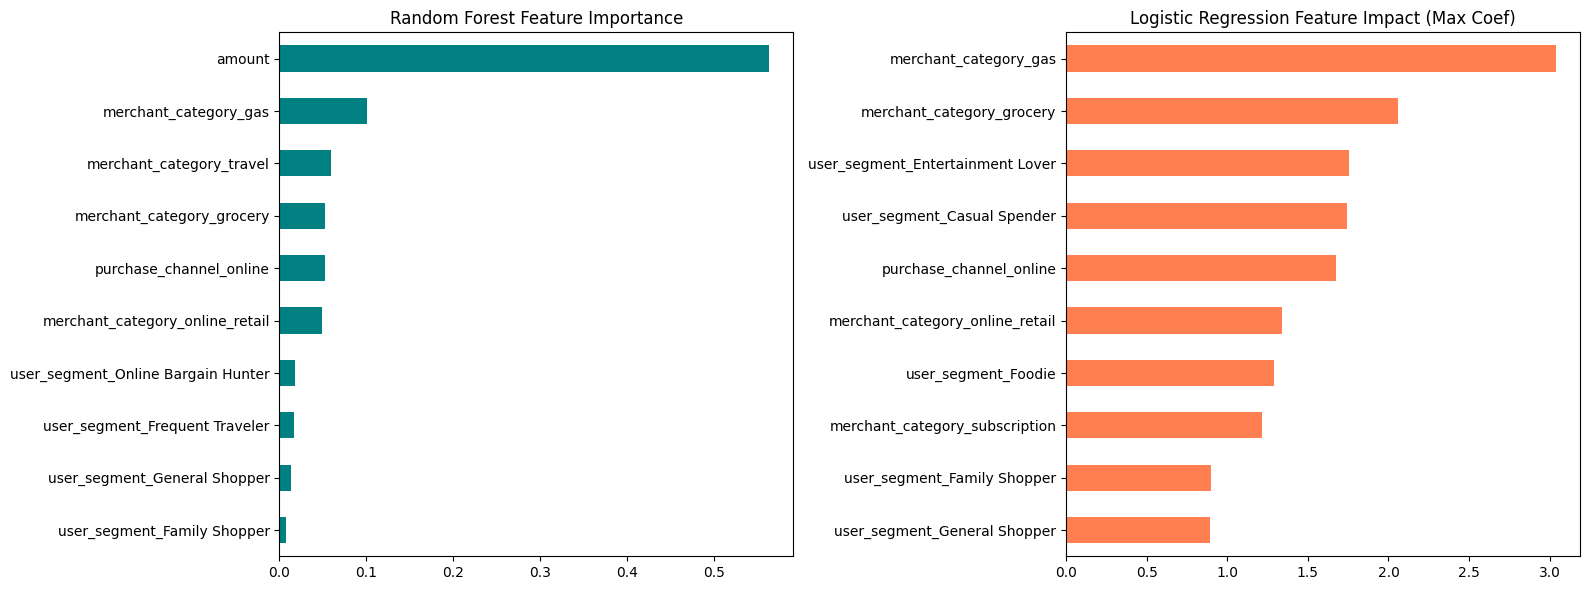

In [24]:
import matplotlib.pyplot as plt
rf_importances = pd.Series(rf.feature_importances_, index=X_train.columns)

lr_importance = pd.Series(np.max(np.abs(lr.coef_), axis=0), index=X_train.columns)
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

rf_importances.nlargest(10).sort_values().plot(kind='barh', ax=ax[0], color='teal')
ax[0].set_title("Random Forest Feature Importance")

lr_importance.nlargest(10).sort_values().plot(kind='barh', ax=ax[1], color='coral')
ax[1].set_title("Logistic Regression Feature Impact (Max Coef)")

plt.tight_layout()
plt.show()

In [25]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
print("Mapping:", dict(zip(le.classes_, range(len(le.classes_)))))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Data scaled and encoded.")

Mapping: {'Card_Flat': 0, 'Card_Grocery': 1, 'Card_Travel': 2}
Data scaled and encoded.


XG Boost model

In [26]:
import xgboost as xgb

print("TRAINING: XGBoost")

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

xgb_model.fit(X_train, y_train_enc)
y_pred_xgb = xgb_model.predict(X_test)

print("\n XGBoost Results")
print(f"Accuracy: {accuracy_score(y_test_enc, y_pred_xgb):.3f}")
print(f"F1 Score: {f1_score(y_test_enc, y_pred_xgb, average='weighted'):.3f}")

TRAINING: XGBoost

 XGBoost Results
Accuracy: 0.989
F1 Score: 0.989


Small Feed-Forward Neural Network (MLP)

In [27]:
from sklearn.neural_network import MLPClassifier

print("TRAINING: Neural Network (MLP)")

mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    max_iter=1000,
    random_state=42
)

mlp.fit(X_train_scaled, y_train_enc)

y_pred_mlp = mlp.predict(X_test_scaled)

print("\n Neural Network (MLP) Results")
print(f"Accuracy: {accuracy_score(y_test_enc, y_pred_mlp):.3f}")
print(f"F1 Score: {f1_score(y_test_enc, y_pred_mlp, average='weighted'):.3f}")

TRAINING: Neural Network (MLP)

 Neural Network (MLP) Results
Accuracy: 0.944
F1 Score: 0.944


Support Vector Machine (SVM)

In [28]:
from sklearn.svm import SVC

print("TRAINING: Support Vector Machine (SVM)")

svm = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=42
)

svm.fit(X_train_scaled, y_train_enc)
y_pred_svm = svm.predict(X_test_scaled)

print("\n SVM Results")
print(f"Accuracy: {accuracy_score(y_test_enc, y_pred_svm):.3f}")
print(f"F1 Score: {f1_score(y_test_enc, y_pred_svm, average='weighted'):.3f}")

TRAINING: Support Vector Machine (SVM)

 SVM Results
Accuracy: 0.740
F1 Score: 0.745


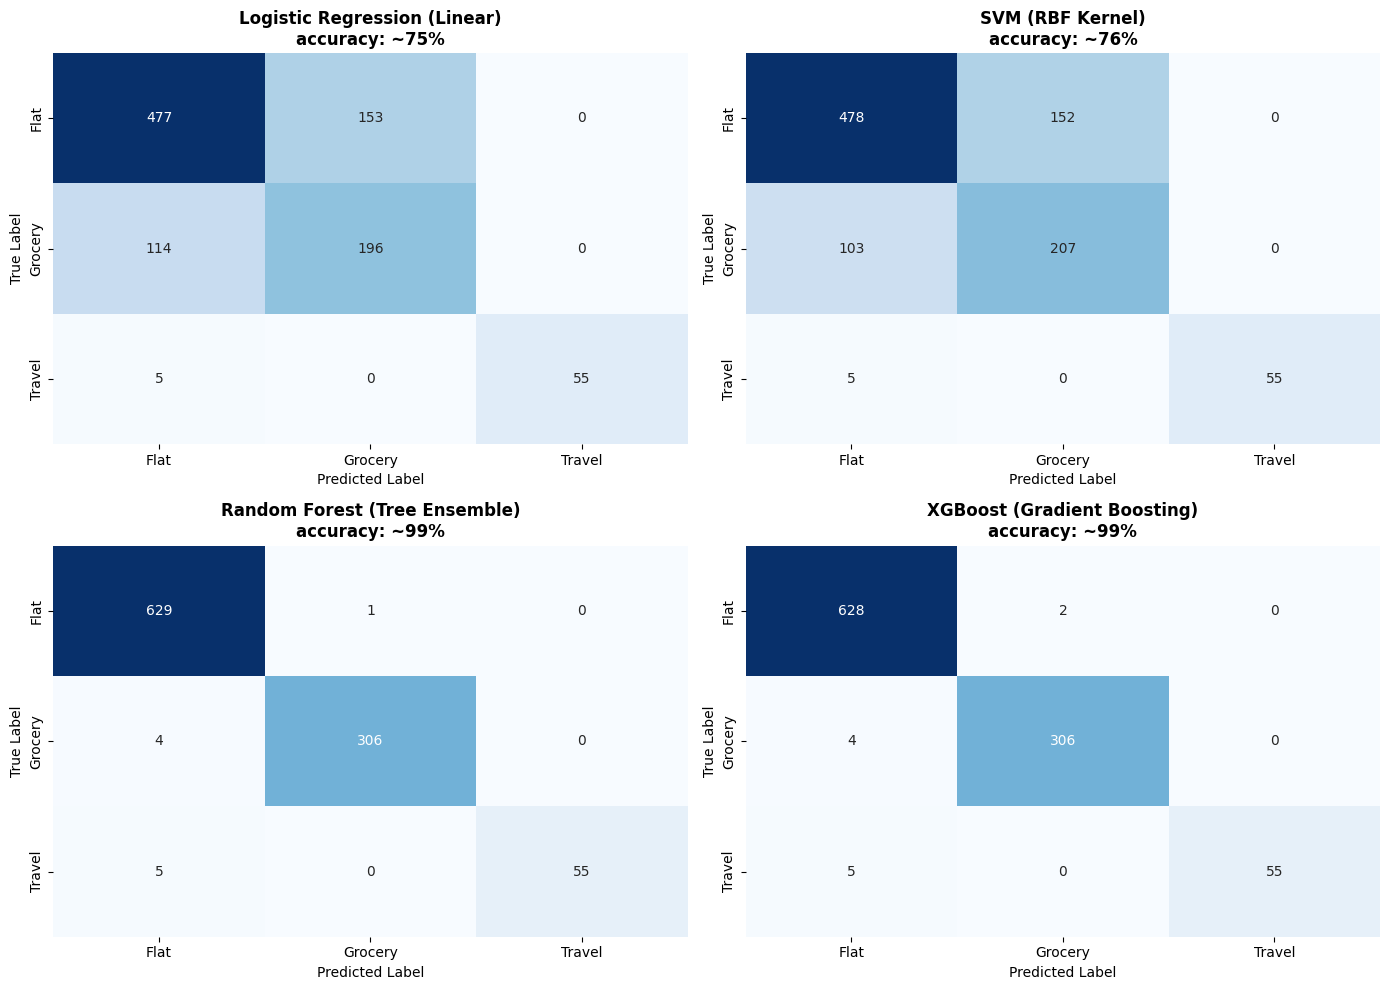

In [29]:

# CONFUSION MATRIX

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred_xgb_str = le.inverse_transform(y_pred_xgb)
y_pred_svm_str = le.inverse_transform(y_pred_svm)


def plot_cm(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred, labels=['Card_Flat', 'Card_Grocery', 'Card_Travel'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Flat', 'Grocery', 'Travel'],
                yticklabels=['Flat', 'Grocery', 'Travel'], ax=ax)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plot_cm(y_test, y_pred_lr, "Logistic Regression (Linear)\naccuracy: ~75%", axes[0,0])
plot_cm(y_test, y_pred_svm_str, "SVM (RBF Kernel)\naccuracy: ~76%", axes[0,1])
plot_cm(y_test, y_pred_rf, "Random Forest (Tree Ensemble)\naccuracy: ~99%", axes[1,0])
plot_cm(y_test, y_pred_xgb_str, "XGBoost (Gradient Boosting)\naccuracy: ~99%", axes[1,1])

plt.tight_layout()
plt.show()

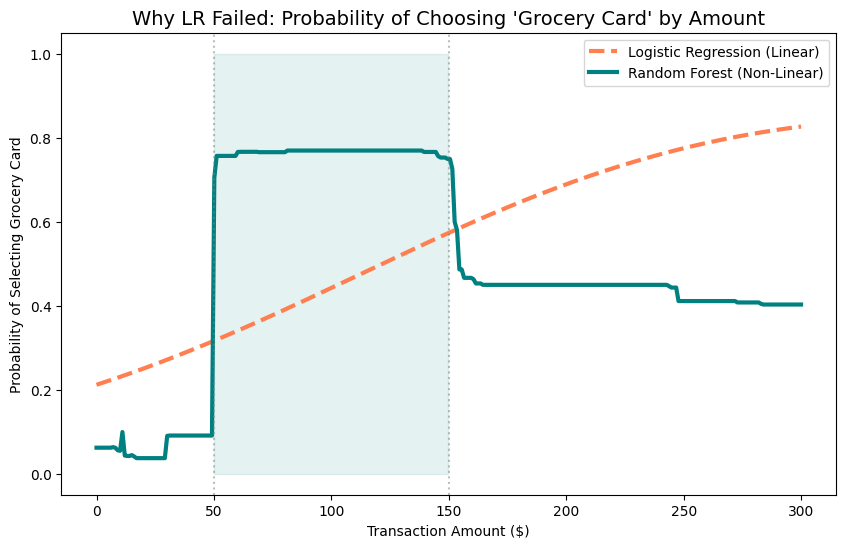

In [30]:

import seaborn as sns
test_amts = np.linspace(0, 300, 300)
viz_df = pd.DataFrame({
    'amount': test_amts,
    'merchant_category_grocery': 1,
    'merchant_category_travel': 0,
    'merchant_category_gas': 0,
    'merchant_category_dining': 0,
    'merchant_category_online_retail': 0,
    'merchant_category_subscription': 0,
    'purchase_channel_online': 0,
    'country_Non-US': 0,

    'month_6': 0, 'month_7': 0, 'user_segment_Family Shopper': 1

})


missing_cols = set(X_train.columns) - set(viz_df.columns)
for c in missing_cols: viz_df[c] = 0
viz_df = viz_df[X_train.columns]


lr_probs = lr.predict_proba(viz_df)
rf_probs = rf.predict_proba(viz_df)


plt.figure(figsize=(10, 6))
plt.plot(test_amts, lr_probs[:, 1], label='Logistic Regression (Linear)', color='coral', linewidth=3, linestyle='--')
plt.plot(test_amts, rf_probs[:, 1], label='Random Forest (Non-Linear)', color='teal', linewidth=3)

plt.axvline(50, color='gray', linestyle=':', alpha=0.5)
plt.axvline(150, color='gray', linestyle=':', alpha=0.5)
plt.title("Why LR Failed: Probability of Choosing 'Grocery Card' by Amount", fontsize=14)
plt.xlabel("Transaction Amount ($)")
plt.ylabel("Probability of Selecting Grocery Card")
plt.legend()
plt.fill_between(test_amts, 0, 1, where=(test_amts>50)&(test_amts<150), color='teal', alpha=0.1, label='Actual "Sweet Spot"')
plt.show()

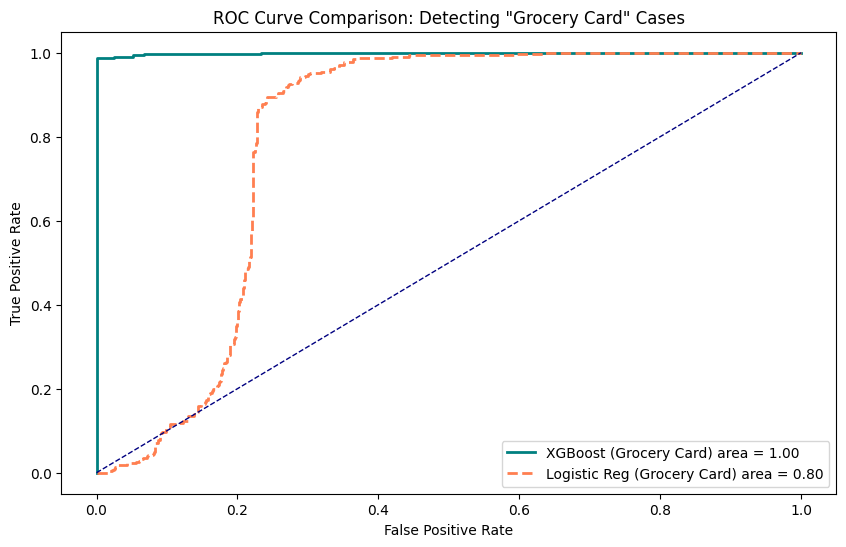

In [31]:
# ROC CURVES
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_bin = label_binarize(y_test_enc, classes=[0, 1, 2])
n_classes = 3


y_score_xgb = xgb_model.predict_proba(X_test)
y_score_lr = lr.predict_proba(X_test)

plt.figure(figsize=(10, 6))

# Plot ROC for "Grocery Card"
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_bin[:, 1], y_score_xgb[:, 1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_lr, tpr_lr, _ = roc_curve(y_test_bin[:, 1], y_score_lr[:, 1])
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.plot(fpr_xgb, tpr_xgb, color='teal', lw=2, label=f'XGBoost (Grocery Card) area = {roc_auc_xgb:.2f}')
plt.plot(fpr_lr, tpr_lr, color='coral', lw=2, linestyle='--', label=f'Logistic Reg (Grocery Card) area = {roc_auc_lr:.2f}')

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Detecting "Grocery Card" Cases')
plt.legend(loc="lower right")
plt.show()

Monetary Regret Calculation

Calculating the financial impact...
------------------------------
Total Transactions: 1000
Total Money 'Left on the Table': $0.81
Average Regret per Txn:        $0.0008
Max Regret (Worst mistake):    $1.53
------------------------------


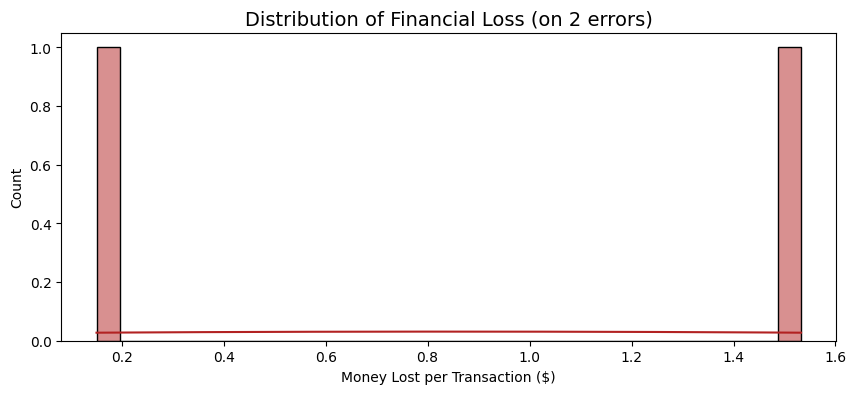

In [32]:



def get_actual_reward(row, card_name):
    amt = row['amount']
    cat = row['merchant_category']
    r_flat = amt * 0.02


    if cat == 'grocery' and 50 <= amt <= 150:
        r_grocery = amt * 0.05
    elif cat == 'gas' and amt < 60:
        r_grocery = amt * 0.04
    else:
        r_grocery = amt * 0.01


    if cat == 'dining' and 20 <= amt <= 100:
        r_travel = amt * 0.04
    elif cat == 'travel' and amt > 300:
        r_travel = amt * 0.03 + 10
    else:
        r_travel = amt * 0.01


    if card_name == "Card_Flat": return r_flat
    if card_name == "Card_Grocery": return r_grocery
    if card_name == "Card_Travel": return r_travel
    return 0.0


test_df = X_test.copy()

test_df['merchant_category'] = df.loc[test_df.index, 'merchant_category']
test_df['true_best_card'] = y_test
test_df['pred_card'] = le.inverse_transform(y_pred_xgb)

print("Calculating the financial impact...")

test_df['actual_value'] = test_df.apply(
    lambda r: get_actual_reward(r, r['pred_card']), axis=1
)

test_df['optimal_value'] = test_df.apply(
    lambda r: get_actual_reward(r, r['true_best_card']), axis=1
)

# REGRET CALCULATION
test_df['regret'] = test_df['optimal_value'] - test_df['actual_value']


print("-" * 30)
print(f"Total Transactions: {len(test_df)}")
print(f"Total Money 'Left on the Table': ${test_df['regret'].sum():,.2f}")
print(f"Average Regret per Txn:        ${test_df['regret'].mean():.4f}")
print(f"Max Regret (Worst mistake):    ${test_df['regret'].max():.2f}")
print("-" * 30)


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 4))
mistakes = test_df[test_df['regret'] > 0]
if len(mistakes) > 0:
    sns.histplot(mistakes['regret'], bins=30, color='firebrick', kde=True)
    plt.title(f"Distribution of Financial Loss (on {len(mistakes)} errors)", fontsize=14)
    plt.xlabel("Money Lost per Transaction ($)")
    plt.ylabel("Count")
    plt.show()
else:
    print("ero regret. The model was perfect.")